# EE 511 Assignment 4 - PartII
University of Washington<br>
Code by John Ragland and Doruk Arisoy<br>
Winter 2021

In [2]:
# Suppress Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import random
import numpy as np
import tools
import loadgalaxy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA

# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the data

In [3]:
imgs_train, imgs_val, imgs_test = loadgalaxy.LoadData()

Loading Training Data...
(40872, 400)
Loading Validation Data...
(10382, 400)
Loading Test Data...
(10324, 400)


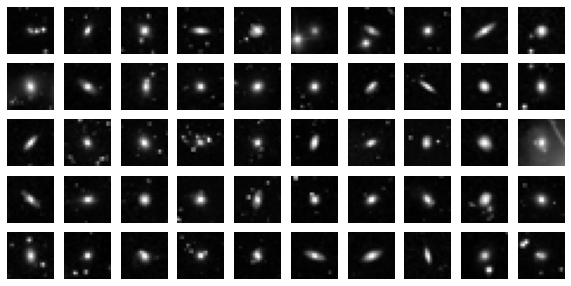

In [4]:
# Plot Random Sample of Images
img_idx = random.sample(range(0, len(imgs_train)-1), 50)
fig, axes = plt.subplots(5,10, figsize=(10,5))

for k, ax in enumerate(fig.get_axes()):
    plt.sca(ax)
    plt.imshow(np.reshape(imgs_train[img_idx[k]],(20,20)),cmap='gray')
    plt.axis('off')

## Play around with PCA

In [7]:
pca = PCA(n_components=25)
converted_val = pca.fit_transform(imgs_val)
inverted_val = pca.inverse_transform(converted_val)
converted_test = pca.fit_transform(imgs_test)
inverted_test = pca.inverse_transform(converted_test)

criterion = nn.MSELoss()
print('PCA MSE on validation: %.2f' % criterion(torch.Tensor(inverted_val), torch.Tensor(imgs_val)))
print('PCA MSE on testing: %.2f' % criterion(torch.Tensor(inverted_test), torch.Tensor(imgs_test)))

PCA MSE on validation: 37.38
PCA MSE on testing: 37.30


## Train an autoencoder

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(400, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 25)
        self.fc4 = nn.Linear(25, 100)
        self.fc5 = nn.Linear(100, 200)
        self.fc6 = nn.Linear(200, 400)

    def forward_encoder(self, x):
        x = x / 255.0
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x
    
    def forward_decoder(self, x):
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = self.fc6(x)
        return x * 255
    
    def forward(self, x, path='full'):
        '''
        Parameters
        ----------
        x : pytorch tensor
            Input data
        path : str
            'full' (Default) does full encoder -> decoder cycle
            'enc' only encodes data (output vector will be)
        '''

        if path == 'full':
            x = self.forward_encoder(x)
            x = self.forward_decoder(x)
        elif path == 'enc':
            x = self.forward_encoder(x)
        else:
            raise Exception('Invalid path options "full", "enc"')
            
        return x

In [6]:
BATCH_SIZE = 100
TEST_BATCH_SIZE = 1000
EPOCHS = 80
LEARNING_RATE = 0.001
MOMENTUM = 0.5
SEED = 0
LOG_INTERVAL = 10000

In [7]:
torch.manual_seed(SEED)
device = torch.device("cpu")
print('Using device', device)
import multiprocessing
print('num cpus:', multiprocessing.cpu_count()) 
criterion = nn.MSELoss()

Using device cpu
num cpus: 12


In [8]:
data_train = torch.Tensor(imgs_train)
data_train = TensorDataset(data_train, data_train)
data_valid = torch.Tensor(imgs_val)
data_valid = TensorDataset(data_valid, data_valid)
data_test = torch.Tensor(imgs_test)
data_test = TensorDataset(data_test, data_test)

train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 
valid_loader = DataLoader(dataset = data_valid, batch_size = BATCH_SIZE,  shuffle = False)
test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE,  shuffle = False)

In [9]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
tools.train(model, device, train_loader, optimizer, EPOCHS, LOG_INTERVAL, criterion, verbose=True)

Train Epoch: 0 [0/40872 (0%)]	Loss: 545.070312
Train Epoch: 1 [0/40872 (0%)]	Loss: 80.988167
Train Epoch: 2 [0/40872 (0%)]	Loss: 82.003784
Train Epoch: 3 [0/40872 (0%)]	Loss: 69.837959
Train Epoch: 4 [0/40872 (0%)]	Loss: 78.125954
Train Epoch: 5 [0/40872 (0%)]	Loss: 55.673077
Train Epoch: 6 [0/40872 (0%)]	Loss: 71.378334
Train Epoch: 7 [0/40872 (0%)]	Loss: 63.531986
Train Epoch: 8 [0/40872 (0%)]	Loss: 47.369881
Train Epoch: 9 [0/40872 (0%)]	Loss: 62.812363
Train Epoch: 10 [0/40872 (0%)]	Loss: 54.709721
Train Epoch: 11 [0/40872 (0%)]	Loss: 44.557892
Train Epoch: 12 [0/40872 (0%)]	Loss: 45.848373
Train Epoch: 13 [0/40872 (0%)]	Loss: 43.548466
Train Epoch: 14 [0/40872 (0%)]	Loss: 51.961681
Train Epoch: 15 [0/40872 (0%)]	Loss: 56.055412
Train Epoch: 16 [0/40872 (0%)]	Loss: 45.326092
Train Epoch: 17 [0/40872 (0%)]	Loss: 42.029518
Train Epoch: 18 [0/40872 (0%)]	Loss: 42.121746
Train Epoch: 19 [0/40872 (0%)]	Loss: 43.745274
Train Epoch: 20 [0/40872 (0%)]	Loss: 48.109764
Train Epoch: 21 [0/408

In [10]:
print('Total MSE loss on validation data: %.2f' % tools.average_loss(model, criterion, imgs_val))
print('Total MSE loss on testing data: %.2f' % tools.average_loss(model, criterion, imgs_test))

Total MSE loss on validation data: 28.55
Total MSE loss on testing data: 28.62


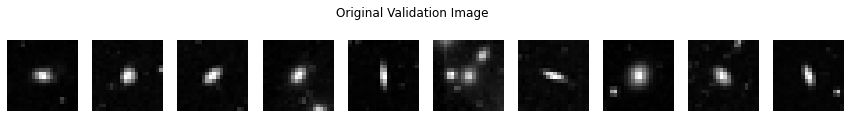

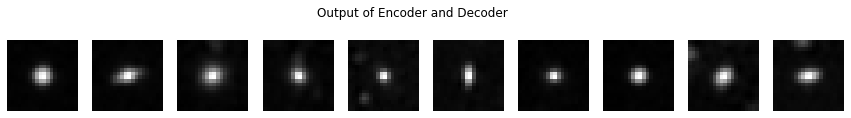

In [11]:
img_idx = random.sample(range(0, len(imgs_val)-1), 10)

fig1, axes1 = plt.subplots(1,10,figsize=(15,2))
fig1.suptitle('Original Validation Image')
for k, ax in enumerate(fig1.get_axes()):
    plt.sca(ax)
    plt.imshow(np.reshape(imgs_val[img_idx[k]], (20,20)), cmap='gray')
    plt.axis('off')

fig2, axes2 = plt.subplots(1,10,figsize=(15,2))
fig2.suptitle('Output of Encoder and Decoder')
for k, ax in enumerate(fig2.get_axes()):
    output = model(torch.Tensor(imgs_val[k]))
    plt.sca(ax)
    plt.imshow(output.data.reshape(20,20), cmap='gray')
    plt.axis('off')


## PCA vs Autoencoder Visual Comparison

In [12]:
auto_losses = tools.loss_array(model, criterion, imgs_test)

(-0.5, 19.5, 19.5, -0.5)

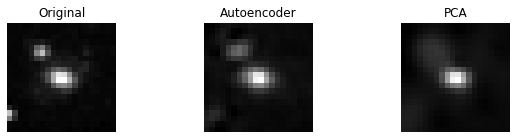

In [13]:
i = 0
while auto_losses[i] >= criterion(torch.Tensor(inverted_test[i]), torch.Tensor(imgs_test[i])):
    i += 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,2))
plt.sca(ax1)
ax1.set_title('Original')
plt.imshow(np.reshape(imgs_test[i], (20,20)), cmap='gray')
plt.axis('off')
plt.sca(ax2)
ax2.set_title('Autoencoder')
plt.imshow(model(torch.Tensor(imgs_test[i])).data.reshape(20,20), cmap='gray')
plt.axis('off')
plt.sca(ax3)
ax3.set_title('PCA')
plt.imshow(np.reshape(inverted_test[i], (20,20)), cmap='gray')
plt.axis('off')

(-0.5, 19.5, 19.5, -0.5)

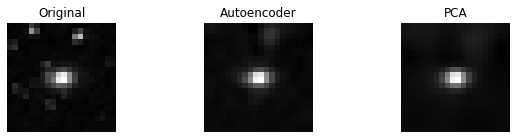

In [14]:
j = 0
while auto_losses[j] <= criterion(torch.Tensor(inverted_test[j]), torch.Tensor(imgs_test[j])):
    j += 1

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,2))
plt.sca(ax1)
ax1.set_title('Original')
plt.imshow(np.reshape(imgs_test[j], (20,20)), cmap='gray')
plt.axis('off')
plt.sca(ax2)
ax2.set_title('Autoencoder')
plt.imshow(model(torch.Tensor(imgs_test[j])).data.reshape(20,20), cmap='gray')
plt.axis('off')
plt.sca(ax3)
ax3.set_title('PCA')
plt.imshow(np.reshape(inverted_test[j], (20,20)), cmap='gray')
plt.axis('off')

## Looking for Similar Images

In [15]:
# Encode Images and Renmae converted_test
imgs_enc_tens = model(torch.Tensor(imgs_test), path='enc')
imgs_enc = imgs_enc_tens.detach().cpu().numpy()
imgs_pca = converted_test

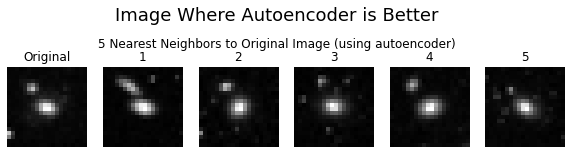

In [16]:
# Train KNN Classifier with arbitrary labels
y = np.zeros(imgs_enc.shape[0])
knn_enc = tools.KNearestNeighbor()
knn_enc.train(imgs_enc,y)
dists = knn_enc.compute_distances(np.expand_dims(imgs_enc[i,:],axis=0))
idx_enc = np.ndarray.flatten(dists.argsort())[1:6]

fig, axes = plt.subplots(1, 6, figsize=(10,2))
plt.figtext(.5,1.1,'Image Where Autoencoder is Better', fontsize=18, ha='center')
fig.suptitle('5 Nearest Neighbors to Original Image (using autoencoder)')
k = 0
for k, ax in enumerate(fig.get_axes()):
    plt.sca(ax)
    if k == 0:
        plt.imshow(np.reshape(imgs_test[i], (20,20)), cmap='gray')
        plt.title('Original')
    else:
        plt.imshow(np.reshape(imgs_test[idx_enc[k-1]],(20,20)), cmap='gray')
        plt.title(f'{k}')
        
    plt.axis('off')
    
fig.savefig('5nn-AE_better_AE.png',bbox_inches='tight')

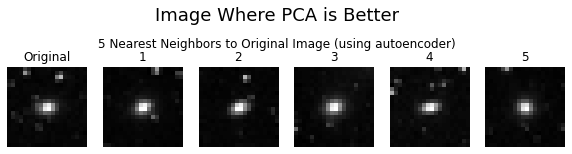

In [17]:
# Train KNN Classifier with arbitrary labels
y = np.zeros(imgs_enc.shape[0])
knn_enc = tools.KNearestNeighbor()
knn_enc.train(imgs_enc,y)
dists = knn_enc.compute_distances(np.expand_dims(imgs_enc[j,:],axis=0))
idx_enc = np.ndarray.flatten(dists.argsort())[1:6]

fig, axes = plt.subplots(1, 6, figsize=(10,2))
plt.figtext(.5,1.1,'Image Where PCA is Better', fontsize=18, ha='center')
fig.suptitle('5 Nearest Neighbors to Original Image (using autoencoder)')
k = 0
for k, ax in enumerate(fig.get_axes()):
    plt.sca(ax)
    if k == 0:
        plt.imshow(np.reshape(imgs_test[j], (20,20)), cmap='gray')
        plt.title('Original')
    else:
        plt.imshow(np.reshape(imgs_test[idx_enc[k-1]],(20,20)), cmap='gray')
        plt.title(f'{k}')
        
    plt.axis('off')
    
fig.savefig('5nn-PCA_better_AE.png',bbox_inches='tight')

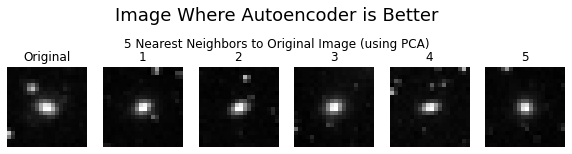

In [18]:
# Train KNN Classifier with arbitrary labels
y = np.zeros(imgs_pca.shape[0])
knn_pca = tools.KNearestNeighbor()
knn_pca.train(imgs_pca,y)
dists = knn_pca.compute_distances(np.expand_dims(imgs_pca[i,:],axis=0))
idx_pca = np.ndarray.flatten(dists.argsort())[1:6]

fig, axes = plt.subplots(1, 6, figsize=(10,2))
plt.figtext(.5,1.1,'Image Where Autoencoder is Better', fontsize=18, ha='center')
fig.suptitle('5 Nearest Neighbors to Original Image (using PCA)')
k = 0
for k, ax in enumerate(fig.get_axes()):
    plt.sca(ax)
    if k == 0:
        plt.imshow(np.reshape(imgs_test[i], (20,20)), cmap='gray')
        plt.title('Original')
    else:
        plt.imshow(np.reshape(imgs_test[idx_enc[k-1]],(20,20)), cmap='gray')
        plt.title(f'{k}')
        
    plt.axis('off')
    
fig.savefig('5nn-AE_better_PCA.png',bbox_inches='tight')

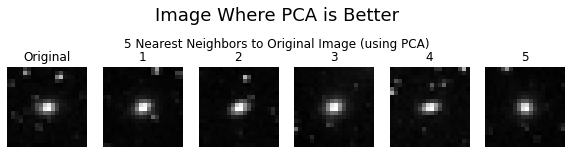

In [20]:
# Train KNN Classifier with arbitrary labels
y = np.zeros(imgs_pca.shape[0])
knn_pca = tools.KNearestNeighbor()
knn_pca.train(imgs_pca,y)
dists = knn_pca.compute_distances(np.expand_dims(imgs_pca[j,:],axis=0))
idx_pca = np.ndarray.flatten(dists.argsort())[1:6]

fig, axes = plt.subplots(1, 6, figsize=(10,2))
plt.figtext(.5,1.1,'Image Where PCA is Better', fontsize=18, ha='center')
fig.suptitle('5 Nearest Neighbors to Original Image (using PCA)')
k = 0
for k, ax in enumerate(fig.get_axes()):
    plt.sca(ax)
    if k == 0:
        plt.imshow(np.reshape(imgs_test[j], (20,20)), cmap='gray')
        plt.title('Original')
    else:
        plt.imshow(np.reshape(imgs_test[idx_enc[k-1]],(20,20)), cmap='gray')
        plt.title(f'{k}')
        
    plt.axis('off')
    
fig.savefig('5nn-PCA_better_PCA.png',bbox_inches='tight')